In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Load Fashion-MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
# Define selected classes
#selected_classes = [1, 3, 6]

# Filter for selected classes
#train_mask = np.isin(y_train, selected_classes)
#test_mask = np.isin(y_test, selected_classes)

#x_train, y_train = x_train[train_mask], y_train[train_mask]
#x_test, y_test = x_test[test_mask], y_test[test_mask]

# Normalize pixel values
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Reshape for CNN
x_train = np.expand_dims(x_train, -1)  # shape: (N, 28, 28, 1)
x_test = np.expand_dims(x_test, -1)

# Remap selected labels to 0, 1, 2
#class_map = {1: 0, 3: 1, 6: 2}
#y_train = np.vectorize(class_map.get)(y_train)
#y_test = np.vectorize(class_map.get)(y_test)

# One-hot encode (now only 3 classes)
y_train_oh = tf.keras.utils.to_categorical(y_train, 10)
y_test_oh = tf.keras.utils.to_categorical(y_test, 10)

x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(
    x_train, y_train_oh,
    test_size=0.1,           # 10% for validation
    random_state=42,         # For reproducibility
    stratify=y_train_oh      # Ensure balanced classes in both splits
)


In [ ]:
from tensorflow.keras import Input
from tensorflow.keras.regularizers import l2

inputs = Input(shape=(28, 28, 1))
x = layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

cnn = tf.keras.Model(inputs=inputs, outputs=outputs)
# Compile & train CNN
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
cnn.fit(
    x_train_split, y_train_split,                    # Training data only
    epochs=20,
    batch_size=64,
    validation_data=(x_val_split, y_val_split),      # Explicit validation data
    callbacks=[callback],
    verbose=1
)

feature_extractor = tf.keras.Model(inputs=cnn.input, outputs=cnn.get_layer(index=-2).output)
features_train = feature_extractor.predict(x_train_split)
features_val = feature_extractor.predict(x_val_split)
features_test = feature_extractor.predict(x_test)

Epoch 1/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 29s 32ms/step - accuracy: 0.6871 - loss: 0.9114 - val_accuracy: 0.8455 - val_loss: 0.4702
Epoch 2/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 25s 29ms/step - accuracy: 0.8458 - loss: 0.4567 - val_accuracy: 0.8613 - val_loss: 0.4129
Epoch 3/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - accuracy: 0.8634 - loss: 0.4083 - val_accuracy: 0.8743 - val_loss: 0.3785
Epoch 4/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 42s 31ms/step - accuracy: 0.8723 - loss: 0.3809 - val_accuracy: 0.8770 - val_loss: 0.3712
Epoch 5/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 39s 29ms/step - accuracy: 0.8820 - loss: 0.3583 - val_accuracy: 0.8838 - val_loss: 0.3429
Epoch 6/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - accuracy: 0.8857 - loss: 0.3425 - val_accuracy: 0.8888 - val_loss: 0.3353
Epoch 7/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 42s 28ms/step - accuracy: 0.8871 - loss: 0.3321 - val_accuracy: 0.8917 - val_loss: 0.3252
Epoch 8/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 42s 29ms/step - accuracy: 0.8955 - loss: 0.3139 - 

In [ ]:
print("Unique train labels:", np.unique(y_train))
print("Train samples:", x_train.shape[0], "Test samples:", x_test.shape[0])

Unique train labels: [0 1 2 3 4 5 6 7 8 9]
Train samples: 60000 Test samples: 10000


In [ ]:
cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 170,144 (664.63 KB)

 Trainable params: 56,714 (221.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 113,430 (443.09 KB)

In [ ]:
print("features_train shape:", features_train.shape)
print("features_test shape:", features_test.shape)
print("Example feature vector (first 5 values):", features_train[0][:5])

features_train shape: (54000, 64)
features_test shape: (10000, 64)
Example feature vector (first 5 values): [0.01499383 3.7070131  1.0909625  0.         0.        ]


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Step 1: Normalize CNN features before PCA
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_val_scaled = scaler.transform(features_val)
features_test_scaled = scaler.transform(features_test)

# Step 2: Apply PCA to reduce to n_qubits
n_qubits = 4
pca = PCA(n_components=n_qubits)

X_train_pca = pca.fit_transform(features_train_scaled)
X_val_pca = pca.transform(features_val_scaled)
X_test_pca = pca.transform(features_test_scaled)

In [ ]:
print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.3f}")

# You might want at least 90-95% variance retention
if pca.explained_variance_ratio_.sum() < 0.9:
    print("Warning: PCA may be losing too much information")

PCA explained variance ratio: [0.22903886 0.14371118 0.09950058 0.08831888]
Total variance explained: 0.561


In [ ]:
print("PCA train shape:", X_train_pca.shape)
print("PCA val shape:", X_val_pca.shape)
print("PCA test shape:", X_test_pca.shape)

PCA train shape: (54000, 4)
PCA val shape: (6000, 4)
PCA test shape: (10000, 4)


In [ ]:
print(f"X_train_pca range: [{X_train_pca.min():.3f}, {X_train_pca.max():.3f}]")
print(f"X_val_pca range: [{X_val_pca.min():.3f}, {X_val_pca.max():.3f}]")
print(f"X_test_pca range: [{X_test_pca.min():.3f}, {X_test_pca.max():.3f}]")

X_train_pca range: [-8.048, 12.443]
X_val_pca range: [-7.369, 10.422]
X_test_pca range: [-7.612, 11.397]


/tmp/ipython-input-11-3415520258.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_2d[:,0], X_2d[:,1], c=y_train_split, cmap='Set1', s=10)


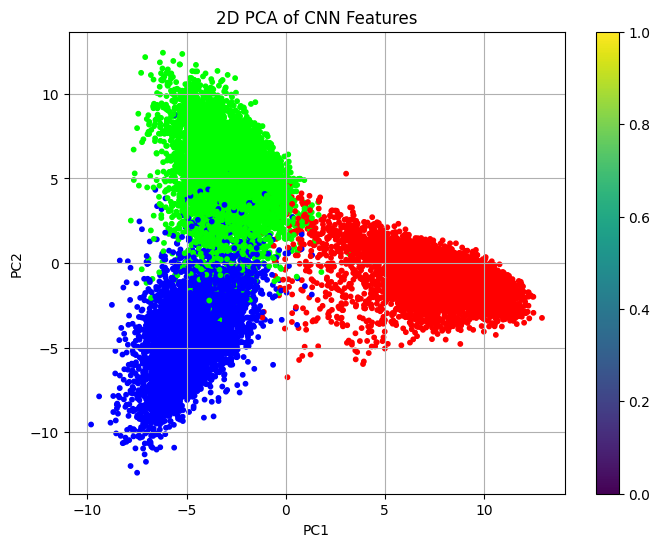

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(features_train_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=y_train_split, cmap='Set1', s=10)
plt.colorbar()
plt.title("2D PCA of CNN Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

In [ ]:
!pip install pennylane==0.41.1

In [ ]:
def scale_for_angular_encoding(X):
    """Scale features to [-π, π] for RY gates"""
    X_min, X_max = X.min(), X.max()
    # First scale to [0, 1]
    X_normalized = (X - X_min) / (X_max - X_min)
    # Then scale to [-π, π]
    X_scaled = 2 * np.pi * X_normalized - np.pi
    return X_scaled

# Apply scaling
X_train_scaled = scale_for_angular_encoding(X_train_pca)
X_val_scaled = scale_for_angular_encoding(X_val_pca)
X_test_scaled = scale_for_angular_encoding(X_test_pca)

# Check new ranges
print(f"X_train_scaled range: [{X_train_scaled.min():.3f}, {X_train_scaled.max():.3f}]")

X_train_scaled range: [-3.142, 3.142]


In [ ]:
y_train_quantum = y_train_split  # These are the labels for quantum training
y_val_quantum = y_val_split      # These are the labels for quantum validation
y_test_quantum = y_test_oh       # These are the labels for quantum testing

In [ ]:
import pennylane as qml
from pennylane import numpy as p_np

n_layers = 4
dev = qml.device("default.qubit", wires=n_qubits)

In [ ]:
@qml.qnode(dev, interface="tf", diff_method="backprop")
def quantum_circuit(inputs, weights):
    inputs = tf.reshape(inputs, [-1])  # Flatten to shape (6,)
    #inputs = tf.cast(inputs, tf.float32)
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    #return tf.stack([qml.expval(qml.PauliZ(i)) for i in range(n_qubits)])
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [ ]:
@qml.qnode(dev, interface="tf", diff_method="backprop")
def quantum_circuit(inputs, weights):
    # Remove the problematic reshape and manual indexing
    # Use amplitude embedding or angle embedding for batched inputs
    qml.AngleEmbedding(inputs, wires=range(n_qubits))

    # Alternative: Use AmplitudeEmbedding if inputs need to be normalized
    # qml.AmplitudeEmbedding(inputs, wires=range(n_qubits), normalize=True)

    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [ ]:
@qml.qnode(dev, interface="tf", diff_method="backprop")
def quantum_circuit(inputs, weights):
    # Each 'inputs' is a single sample of shape (n_qubits,)

    # Encoding inputs using RY gates
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)

    # Apply variational layers
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))

    # Return expectation values
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [ ]:
@qml.qnode(dev, interface="tf", diff_method="backprop")
def quantum_circuit(inputs, weights):
    inputs = tf.reshape(inputs, [-1])
    weights_each_layer = tf.split(weights, num_or_size_splits=n_layers, axis=0)

    for i in range(n_layers):
        for j in range(n_qubits):
            qml.RY(inputs[j], wires=j)  # re-upload inputs
        qml.templates.StronglyEntanglingLayers(weights_each_layer[i], wires=range(n_qubits))

    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [ ]:
weight_shapes = {"weights": (n_layers, n_qubits, 3)}

qlayer = qml.qnn.KerasLayer(quantum_circuit, weight_shapes, output_dim=n_qubits)

inp = tf.keras.Input(shape=(n_qubits,))
q_out = qlayer(inp)
q_out = tf.keras.layers.Dropout(0.3)(q_out)  # Dropout after quantum layer
output = tf.keras.layers.Dense(10, activation="softmax", kernel_regularizer=l2(0.01))(q_out)

hybrid_model = tf.keras.Model(inputs=inp, outputs=output)

/usr/local/lib/python3.11/dist-packages/pennylane/qnn/keras.py:317: PennyLaneDeprecationWarning: The 'KerasLayer' class is deprecated and will be removed in v0.42. 
  warnings.warn(


In [ ]:
print(X_train_pca.shape)  # should be (N, 6)
print(X_train_scaled.shape)
print(y_train_quantum.shape)   # should be (N, 3)

(54000, 4)
(54000, 4)
(54000, 10)


In [ ]:
'''hybrid_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
'''

hybrid_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)
early_stop = EarlyStopping(
    monitor='val_loss',        # or 'val_categorical_accuracy'
    patience=5,                # stop after 2 epochs without improvement
    restore_best_weights=True # revert to best weights after stopping
)
'''
history = hybrid_model.fit(
    X_train_pca,
    y_train_oh,
    validation_split=0.1,
    epochs=20,
    batch_size=1,  # Must be 1 unless you rewrite your QNode for batches
    callbacks=[early_stop]
    verbose=1
)
'''
history = hybrid_model.fit(
    X_train_scaled,                                    # Training data only
    y_train_quantum,                                # Training labels only
    validation_data=(X_val_scaled, y_val_quantum),    # Explicit validation data
    epochs=20,
    batch_size=8,                                  # Increased from 1
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20


6750/6750 ━━━━━━━━━━━━━━━━━━━━ 81s 11ms/step - categorical_accuracy: 0.1835 - loss: 2.2265 - val_categorical_accuracy: 0.3795 - val_loss: 1.9700
Epoch 2/20
6750/6750 ━━━━━━━━━━━━━━━━━━━━ 80s 11ms/step - categorical_accuracy: 0.3870 - loss: 1.9287 - val_categorical_accuracy: 0.4847 - val_loss: 1.7836
Epoch 3/20
6750/6750 ━━━━━━━━━━━━━━━━━━━━ 81s 10ms/step - categorical_accuracy: 0.4546 - loss: 1.7879 - val_categorical_accuracy: 0.5458 - val_loss: 1.7109
Epoch 4/20
6750/6750 ━━━━━━━━━━━━━━━━━━━━ 83s 10ms/step - categorical_accuracy: 0.4869 - loss: 1.7366 - val_categorical_accuracy: 0.5643 - val_loss: 1.6810
Epoch 5/20
6750/6750 ━━━━━━━━━━━━━━━━━━━━ 81s 10ms/step - categorical_accuracy: 0.5065 - loss: 1.7178 - val_categorical_accuracy: 0.5673 - val_loss: 1.6648
Epoch 6/20
6750/6750 ━━━━━━━━━━━━━━━━━━━━ 85s 11ms/step - categorical_accuracy: 0.5217 - loss: 1.7074 - val_categorical_accuracy: 0.5797 - val_loss: 1.6532
Epoch 7/20
6750/6750 ━━━━━━━━━━━━━━━━━━━━ 70s 10ms/step - categorical_accur

In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = hybrid_model.evaluate(X_test_scaled, y_test_quantum, verbose=1)

print(f"\nTest Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - categorical_accuracy: 0.6864 - loss: 1.4752

Test Results:
Test Loss: 1.4738
Test Accuracy: 0.6819


In [ ]:
# Try classical model with PCA features
classical_model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(n_qubits,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

classical_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

classical_model.fit(X_train_pca, y_train_quantum,
                   validation_data=(X_val_pca, y_val_quantum),
                   epochs=10, batch_size=32)

classical_test_acc = classical_model.evaluate(X_test_pca, y_test_quantum)
print(f"Classical with PCA Test Accuracy: {classical_test_acc[1]:.4f}")

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7117 - loss: 0.9441 - val_accuracy: 0.9633 - val_loss: 0.1056
Epoch 2/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9531 - loss: 0.1396 - val_accuracy: 0.9639 - val_loss: 0.1066
Epoch 3/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9635 - loss: 0.1179 - val_accuracy: 0.9644 - val_loss: 0.1085
Epoch 4/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9657 - loss: 0.1081 - val_accuracy: 0.9639 - val_loss: 0.1084
Epoch 5/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9696 - loss: 0.1009 - val_accuracy: 0.9650 - val_loss: 0.1091
Epoch 6/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9682 - loss: 0.1101 - val_accuracy: 0.9667 - val_loss: 0.1090
Epoch 7/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9674 - loss: 0.0985 - val_accuracy: 0.9656 - val_loss: 0.1120
Epoch 8/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9680 - loss: 0.0972 - val_accuracy: 0.9656 - val_